## Testing out iminuit fitting for FOM, will replace curve fit

In [1]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import probfit

import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

import iminuit
from iminuit import Minuit

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### load and prepare data

In [2]:
#folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/', '75_9e-3/PORT_2b/isaura/']
folder_paths = ['12_12_18/PORT_1a/isaura/','12_12_18/PORT_1b/isaura/', '12_12_18/PORT_2a/isaura/', '12_12_18/PORT_2b/isaura/'] #'15_15_15/PORT_1b/isaura/', '15_15_15/PORT_2a/isaura/', '15_15_15/PORT_2b/isaura/']
full_tracks = func.collate_ports(folder_paths)

# apply cuts, SATELLITE TRACKS ARE DIFFERENT RN
#low_e_tracks = func.remove_low_E_events(full_tracks)
low_e_tracks = full_tracks[full_tracks.energy > 0.05]
# count the number of events identified with unique event, and change numb_of_tracks to reflect this
event_counts = low_e_tracks['event'].value_counts(sort = False)

# apply this to numb_of_tracks
low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)



Porting 12_12_18/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 12_12_18/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 12_12_18/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973
Porting 12_12_18/PORT_2b/isaura/
50
100
150
200
250
300
Tracks: 80864
Done! Tracks available: 259847


/tmp/ipykernel_8877/2551554132.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.10 %
Absolute Cut efficiency:
Efficiency: 40.10 %
One track cut
Relative Cut efficiency:
Efficiency: 62.40 %
Absolute Cut efficiency:
Efficiency: 50.68 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 82.16 %
Absolute Cut efficiency:
Efficiency: 78.65 %
Energy cut
Relative Cut efficiency:
Efficiency: 8.78 %
Absolute Cut efficiency:
Efficiency: 7.43 %


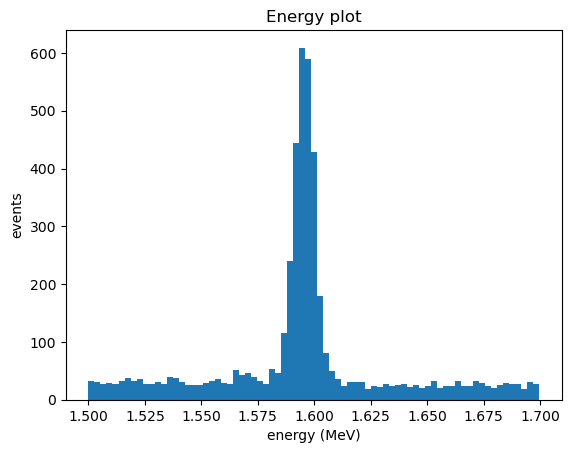

In [3]:
func.plot_hist(cut_tracks[0], binning = 75, log = False)

In [4]:
# find positron events per port
pos_events = func.positron_ports(folder_paths)

Loading positrons from 12_12_18/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 12_12_18/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 12_12_18/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976
Loading positrons from 12_12_18/PORT_2b/isaura/
Positron events: 12817
Port finished! Tracks available: 47202


In [6]:
# collect positron events and non-positron events
ecut_positron_df = cut_tracks[0][cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
ecut_no_positron_df = cut_tracks[0][~cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

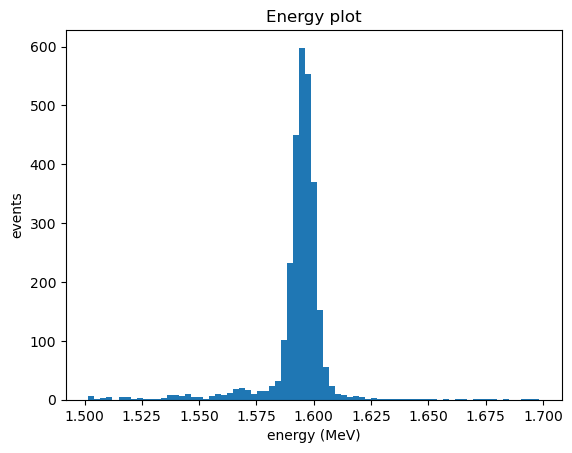

In [7]:
func.plot_hist(ecut_positron_df, binning = 75, log = False)

In [26]:
cut_list = np.linspace(0,0.35, 36)

# Fit
#fom_out_fit = func.fom_calc_MC(cut_tracks[0], pos_events, cut_list, binning = 60)

In [8]:
def fit(c, C1, C2, mu, sigma):
    m = Minuit(c, ns = 400, a = 1, nb = 20, tau = 0.1, C1 = C1, C2 = C2, mu = mu, sigma = sigma)
    m.fixed['mu'] = True
    m.fixed['sigma'] = True
    m.fixed['C1'] = True
    m.fixed['C2'] = True
    m.limits["ns", "nb"] = (0, None)
    m.migrad()
    assert m.valid
    return m

In [9]:
# create a distribution function for the bins
def integral(xe, ns, a, mu, sigma, C1, C2, nb, tau):

    return ns * skewnorm_func.cdf(x, a, mu, sigma) + C1 

### unbinned extended maximum likelihood fit for C1 C2 

In [9]:
# set range we're considering
fit_range = (1.5, 1.7)
binning = 80

In [10]:
def bck_func_no_N(x, tau):
    return np.exp(-x/tau)

def gauss_no_N(x, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return np.exp(-numer/denom)

In [11]:
# Normalise and extend
sig_norm = probfit.Normalized(func.sig_func_no_N, fit_range)
sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

bck_norm = probfit.Normalized(bck_func_no_N, fit_range)
bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

gauss_norm = probfit.Normalized(gauss_no_N, fit_range)
gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

### collecting C1 and C2 parameters

In [12]:

e_s = ecut_positron_df['energy'].to_numpy()
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)



In [13]:
# minimise that mfer
m.migrad()

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   -27204.3871273 Edm =      1512.55 NCalls =    121
VariableMetric: Iteration #   0 - FCN =   -27204.3871273 Edm =      1512.55 NCalls =    121
VariableMetric: Iteration #   1 - FCN =  -28335.26411278 Edm =      1087.18 NCalls =    141
VariableMetric: Iteration #   2 - FCN =  -29845.28346666 Edm =      629.843 NCalls =    166
VariableMetric: Iteration #   3 - FCN =  -29895.53825929 Edm =      47.2652 NCalls =    180
VariableMetric: Iteration #   4 - FCN =  -29910.25411894 Edm =      8.91856 NCalls =    194
VariableMetric: Iteration #   5 - FCN =  -29914.79184044 Edm =     0.704347 NCalls =    208
VariableMetric: Iteration #   6 - FCN =  -29915.90929547 Edm =      0.58868 NCalls =    222
VariableMetric: Iteration #   7 - FCN =  -29922.66184601 Edm =      2.00416 NCalls =    241
VariableMetric: Iteration #   8 - FCN =  -29927.25870175 Edm =     0.475589 NCalls =    255
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -2.993e+04                 │        Nfcn = 339 (339 total)        │
│ EDM = 5.62e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.69    │   0.27    │            │            │         │         │       │
│ 1 │ mu    │  1.5933   │  0.0008   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  5.0e-3   │  0.4e-3   │            │            │    0    │         │       │
│ 3 │ C1    │   0.41    │   0.04    │            │            │    0    │         │       │
│ 4 │ C2    │   0.269   │   0.035   │            │            │    0    │         │       │
│ 5 │ Ns    │  2.88e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

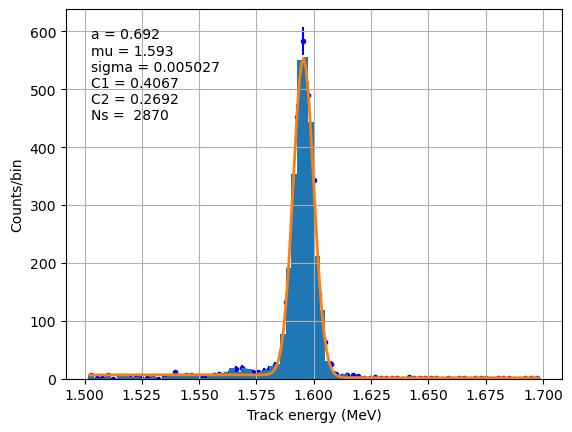

"\nC1_test = 1\nx_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE\ny_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)\nplt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))\nplt.ylim([0,600])\nplt.legend()\nplt.show()\n"

In [14]:
# plot output
heights, bins, _ = plt.hist(e_s, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)


'''
C1_test = 1
x_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE
y_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)
plt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))
plt.ylim([0,600])
plt.legend()
plt.show()
'''

In [15]:
# collect C1 and C2
print(m.params)
C2 = m.params[4][2]
C1 = m.params[3][2]
# collect the gaussian here as well
mu = m.params[1][2]
sigma = m.params[2][2]

┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.69    │   0.27    │            │            │         │         │       │
│ 1 │ mu    │  1.5933   │  0.0008   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  5.0e-3   │  0.4e-3   │            │            │    0    │         │       │
│ 3 │ C1    │   0.41    │   0.04    │            │            │    0    │         │       │
│ 4 │ C2    │   0.269   │   0.035   │            │            │    0    │         │       │
│ 5 │ Ns    │  2.88e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [16]:
'''
# do signal and background fit over all the data now
e_tracks = cut_tracks[0]['energy'].to_numpy()

# create signal background pdf
pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

lh_sb = probfit.UnbinnedLH(pdf_sb, e_tracks, extended = True)


y, x = np.histogram(e_tracks, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals_sb = [len(e_s), len(e_tracks) - len(e_s), 0, mu, sigma, 100, C1, C2]
nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']



m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)
'''

"\n# do signal and background fit over all the data now\ne_tracks = cut_tracks[0]['energy'].to_numpy()\n\n# create signal background pdf\npdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)\n\nlh_sb = probfit.UnbinnedLH(pdf_sb, e_tracks, extended = True)\n\n\ny, x = np.histogram(e_tracks, fit_bins)\nx = shift_to_bin_centers(x)\n\n\n\n# give it rough starting spots\nvals_sb = [len(e_s), len(e_tracks) - len(e_s), 0, mu, sigma, 100, C1, C2]\nnm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']\n\n\n\nm_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,\n         fix_C2=True, fix_sigma=True, print_level = 2)\n#m.limits['mu'] = (1.4, 1.7)\n#m.limits['C1'] = (0, None)\n#m.limits['C2'] = (0, None)\n#m.limits['sigma'] = (0, None)\n"

In [17]:
'''
# minimise that mfer
m_sb.migrad()
'''

'\n# minimise that mfer\nm_sb.migrad()\n'

In [18]:
'''
# plot output
heights, bins, _ = plt.hist(e_tracks, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_sb.show(bins=binning+1, parts=True)
plt.show()
'''

'\n# plot output\nheights, bins, _ = plt.hist(e_tracks, binning)\nplt.xlabel("Track energy (MeV)")\nplt.ylabel("Counts/bin")\nlh_sb.show(bins=binning+1, parts=True)\nplt.show()\n'

In [19]:
'''
display(m_sb.params)
print(m_sb.params[0][1], m_sb.params[0][2])
print(len(m.params)+1)
'''

'\ndisplay(m_sb.params)\nprint(m_sb.params[0][1], m_sb.params[0][2])\nprint(len(m.params)+1)\n'

In [20]:
def add_element(dict, key, value):
    if key not in dict:
        dict[key] = value
    #dict[key].append(value)

# pull out the relevant values
#fit_params = {}
#[add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

In [21]:
# collect the fom stuff
#ns0 = quad(func.sig_func, fit_range[0], fit_range[1], args = (fit_params['Ns'],fit_params['a'], mu, sigma, C1, C2))#/bin_width
#nb0 = quad(func.bck_func, fit_range[0], fit_range[1], args = (fit_params['Nb'], fit_params['tau']))#/bin_width

#####print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(fit_params['Ns'], fit_params['Nb'],fit_params['Nb'] + fit_params['Ns'], len(cut_tracks[0].index)))

In [22]:
'''
# create list for fom values
e       = []
b       = []
ns_l      = []
nb_l      = []
fom     = []
fom_err = []
e_err = []
b_err = []

ns0 = fit_params['Ns']
nb0 = fit_params['Nb']
ns_l.append(fit_params['Ns'])
nb_l.append(fit_params['Nb'])
'''

"\n# create list for fom values\ne       = []\nb       = []\nns_l      = []\nnb_l      = []\nfom     = []\nfom_err = []\ne_err = []\nb_err = []\n\nns0 = fit_params['Ns']\nnb0 = fit_params['Nb']\nns_l.append(fit_params['Ns'])\nnb_l.append(fit_params['Nb'])\n"

In [23]:
'''
print(ns_l)
print(nb_l)
'''

'\nprint(ns_l)\nprint(nb_l)\n'

### now to create the loop, and collect the gaussian and the full fit on repeat (this takes ages)

In [31]:
#del lh_g
#del m_g 
# create list for fom values
e       = []
b       = []
ns_l      = []
nb_l      = []
fom     = []
fom_err = []
e_err = []
b_err = []


def gaussian_fit(data, plot = False):
    '''
    Fit gaussian to the data
    '''
    blob_np = data['energy'].to_numpy()

    # produce gaussian fit
    lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
    vals_g = [len(blob_np), 1.58, 0.004]
    nm_g = ['Ng', 'mu', 'sigma']

    m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1))
    
    # minimise it
    m_g.migrad()

    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_data, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
    mu = fit_params['mu']
    sigma = fit_params['sigma']


    return (mu, sigma)


def sb_fit(data, mu, sigma, C1, C2, plot = False):
    '''
    Fit signal and background to data
    '''
    blob_np = data['energy'].to_numpy()
    # create signal background pdf
    pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

    lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)
    
    y, x = np.histogram(blob_np, fit_bins)
    x = shift_to_bin_centers(x)
    
    # give it rough starting spots
    vals_sb = [len(blob_np)/2, len(blob_np)/2, 0, mu, sigma, 100, C1, C2]
    nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']

    m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, limit_tau=(0.1,None))

    # minimise that mfer
    m_sb.migrad()

    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_np, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

    return (fit_params['Ns'], fit_params['Nb'])



Blob cut: 0.0 MeV
Mu fit completed, with values:
mu: 1.5954588009253852
sigma: 0.004608316126541034


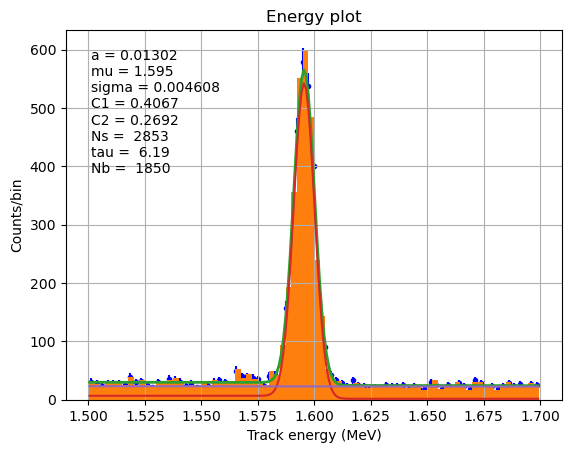

Signal events: 2852.9160112389063
Background events: 1842.5541828057753
Total Events by addition: 4695.470194044681
Total Events by row counting: 4692


Blob cut: 0.01 MeV
Mu fit completed, with values:
mu: 1.5954588009253852
sigma: 0.004608316126541034


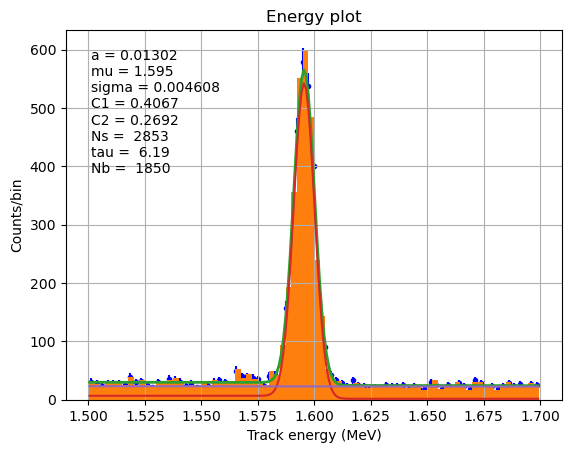

Signal events: 2852.9160112389063
Background events: 1842.5541828057753
Total Events by addition: 4695.470194044681
Total Events by row counting: 4692


Blob cut: 0.02 MeV
Mu fit completed, with values:
mu: 1.5954523465736015
sigma: 0.004614131842677723


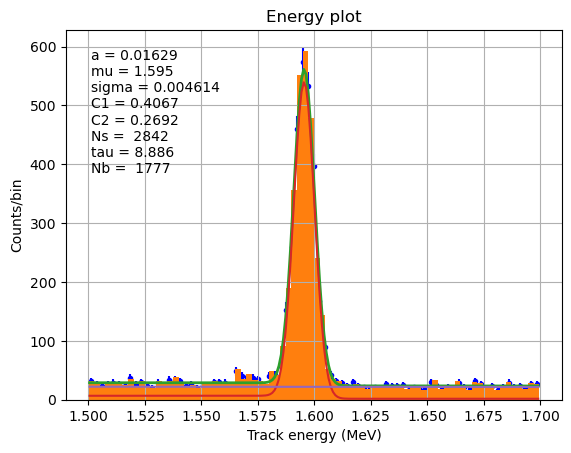

Signal events: 2842.287038847219
Background events: 1770.0866266249666
Total Events by addition: 4612.373665472185
Total Events by row counting: 4609


Blob cut: 0.03 MeV
Mu fit completed, with values:
mu: 1.595438224522613
sigma: 0.004577019176716914


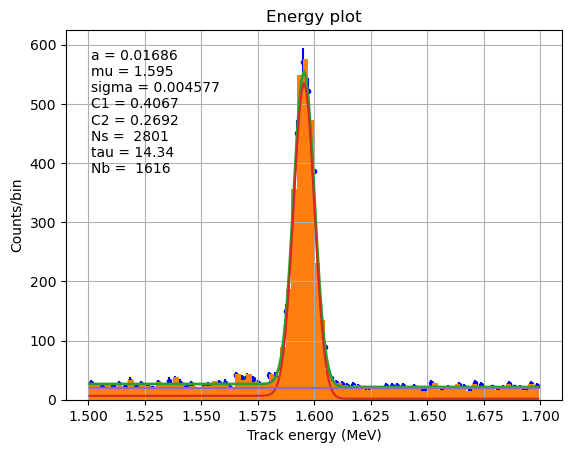

Signal events: 2801.04432022511
Background events: 1609.5400966781167
Total Events by addition: 4410.584416903226
Total Events by row counting: 4404


Blob cut: 0.04 MeV
Mu fit completed, with values:
mu: 1.5954167181810401
sigma: 0.004583286966763853


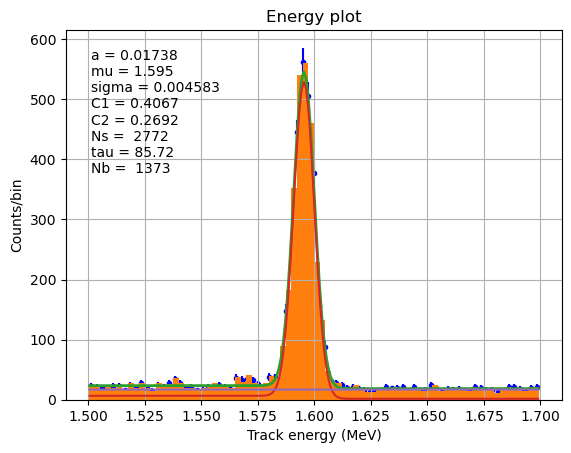

Signal events: 2772.2683287167692
Background events: 1366.5424163275777
Total Events by addition: 4138.810745044347
Total Events by row counting: 4133


Blob cut: 0.05 MeV
Mu fit completed, with values:
mu: 1.5954551764032145
sigma: 0.004547257126988589


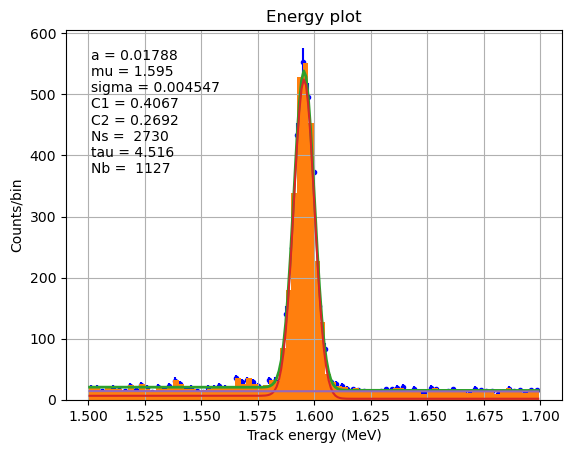

Signal events: 2729.961424035132
Background events: 1122.0155632537878
Total Events by addition: 3851.97698728892
Total Events by row counting: 3847


Blob cut: 0.06 MeV
Mu fit completed, with values:
mu: 1.5954567751145312
sigma: 0.00448625030646923


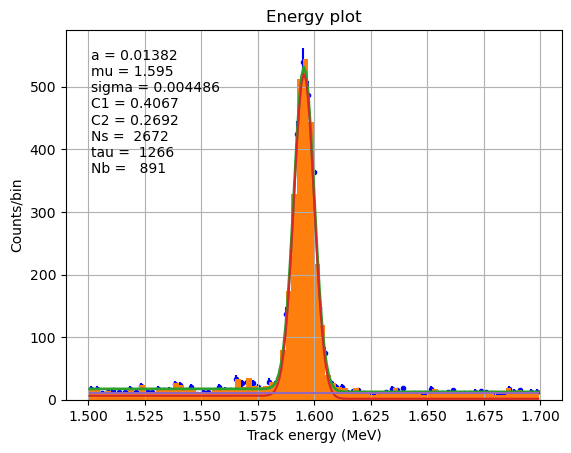

Signal events: 2671.8268797772776
Background events: 886.2427047200476
Total Events by addition: 3558.069584497325
Total Events by row counting: 3554


Blob cut: 0.07 MeV
Mu fit completed, with values:
mu: 1.5954610699585003
sigma: 0.004411160297703703


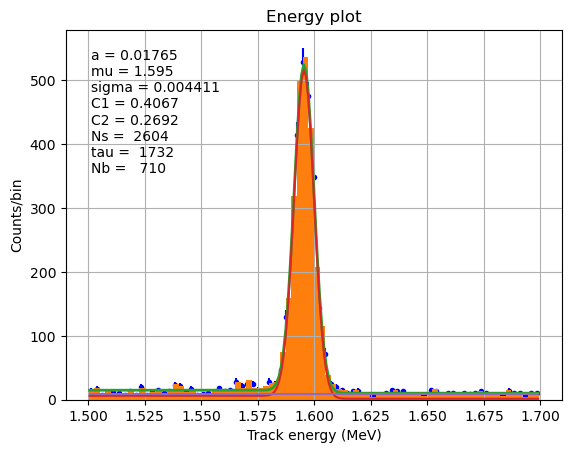

Signal events: 2603.650337559709
Background events: 705.7876320776539
Total Events by addition: 3309.437969637363
Total Events by row counting: 3306


Blob cut: 0.08 MeV
Mu fit completed, with values:
mu: 1.595467295564264
sigma: 0.004381017170962937


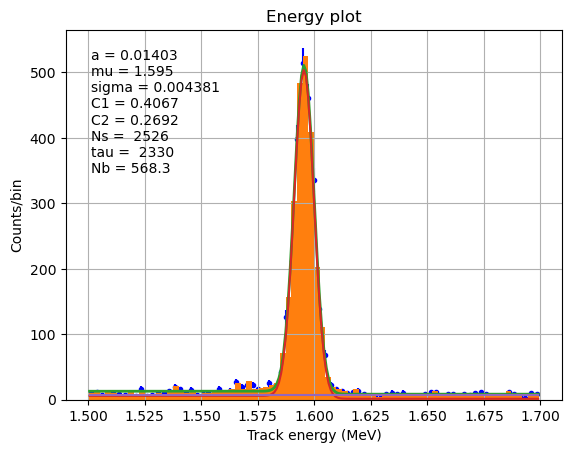

Signal events: 2526.2491932366165
Background events: 564.5528451164877
Total Events by addition: 3090.8020383531043
Total Events by row counting: 3088


Blob cut: 0.09 MeV
Mu fit completed, with values:
mu: 1.5955212435196071
sigma: 0.004299324982529887


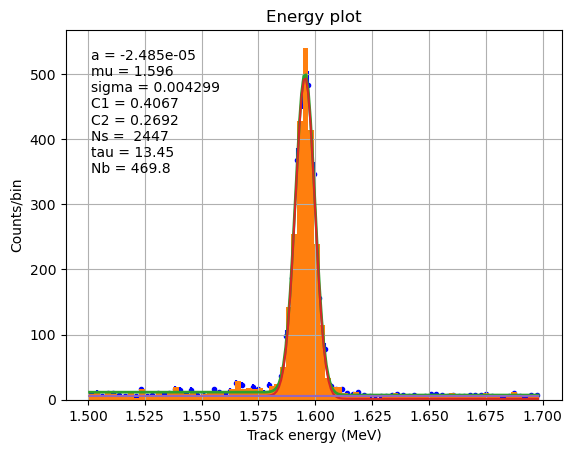

Signal events: 2447.4733425177665
Background events: 466.4608600985571
Total Events by addition: 2913.9342026163235
Total Events by row counting: 2909


Blob cut: 0.1 MeV
Mu fit completed, with values:
mu: 1.595522281335431
sigma: 0.004322321728580353


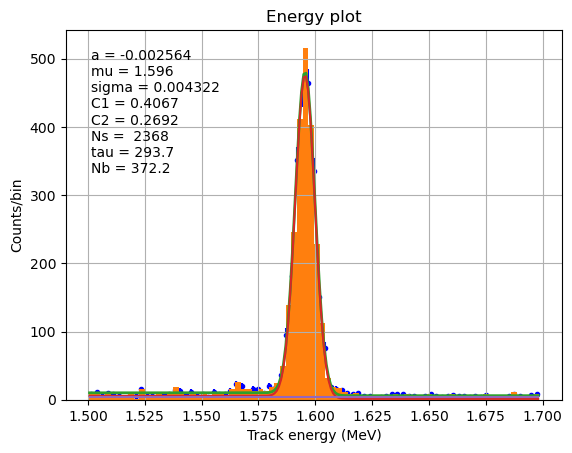

Signal events: 2368.0926654450495
Background events: 369.18786238362287
Total Events by addition: 2737.2805278286723
Total Events by row counting: 2733


Blob cut: 0.11 MeV
Mu fit completed, with values:
mu: 1.5955157574307464
sigma: 0.0043532987688416685


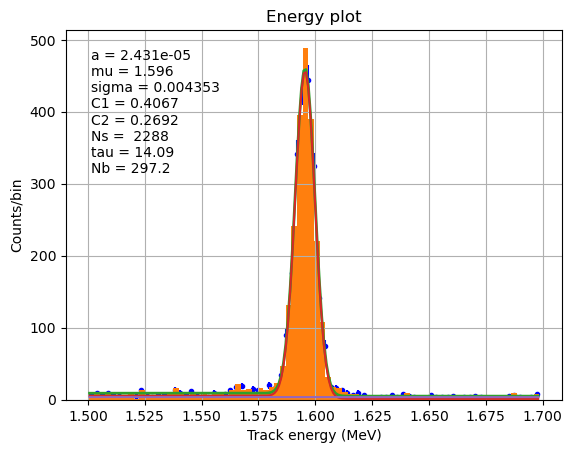

Signal events: 2288.238485368179
Background events: 294.512254938835
Total Events by addition: 2582.750740307014
Total Events by row counting: 2579


Blob cut: 0.12 MeV
Mu fit completed, with values:
mu: 1.5955027610643686
sigma: 0.00433946324226189


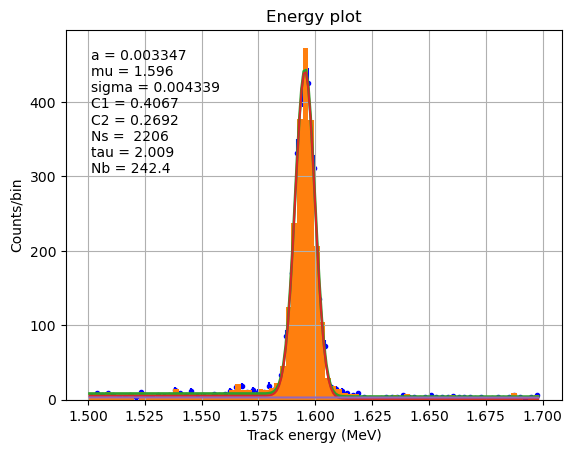

Signal events: 2205.6154687430885
Background events: 242.44659091390213
Total Events by addition: 2448.0620596569906
Total Events by row counting: 2445


Blob cut: 0.13 MeV
Mu fit completed, with values:
mu: 1.5955338273263537
sigma: 0.004364381544085342


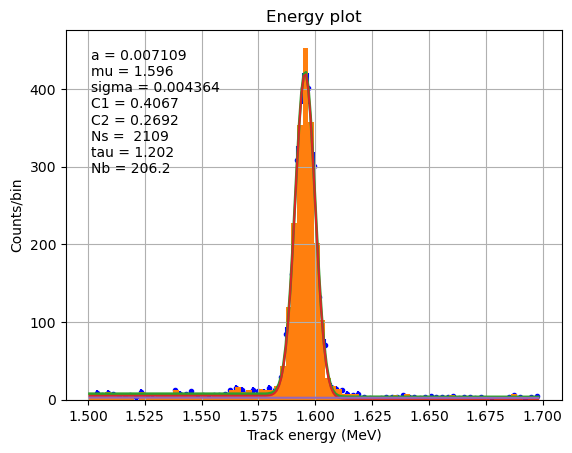

Signal events: 2109.308124635838
Background events: 208.52433427122796
Total Events by addition: 2317.8324589070658
Total Events by row counting: 2315


Blob cut: 0.14 MeV
Mu fit completed, with values:
mu: 1.5955030479362537
sigma: 0.004370091306163316


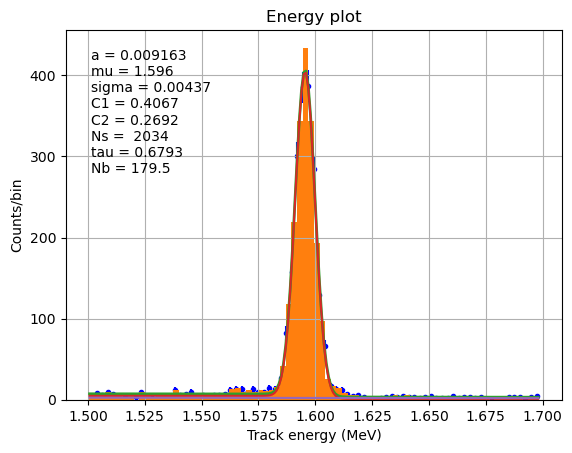

Signal events: 2034.1612758529054
Background events: 177.3121465070554
Total Events by addition: 2211.4734223599608
Total Events by row counting: 2209


Blob cut: 0.15 MeV
Mu fit completed, with values:
mu: 1.595481797038076
sigma: 0.004363144811933697


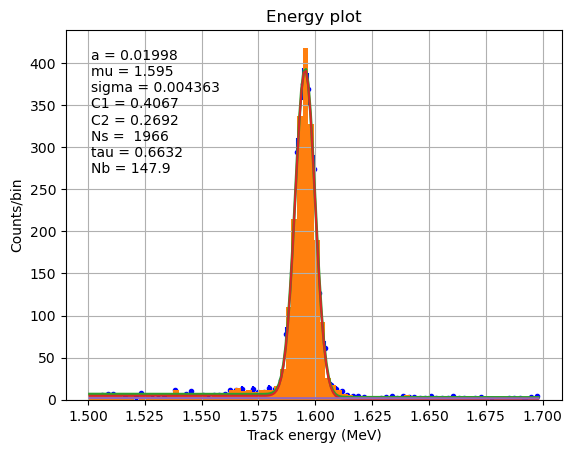

Signal events: 1966.299701938988
Background events: 149.89035951950714
Total Events by addition: 2116.190061458495
Total Events by row counting: 2114


Blob cut: 0.16 MeV
Mu fit completed, with values:
mu: 1.5954830538245957
sigma: 0.004354854027855019


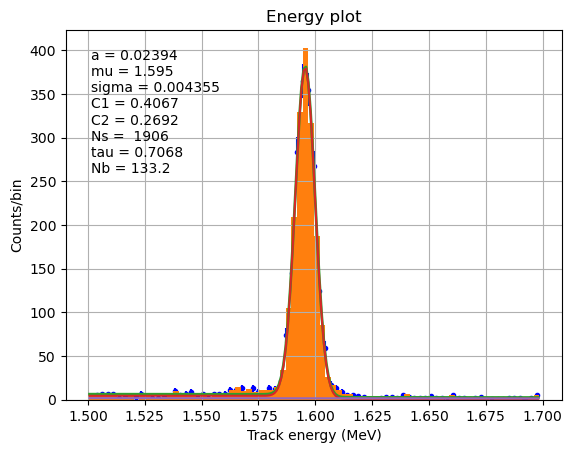

Signal events: 1905.9977024425832
Background events: 135.0535844525986
Total Events by addition: 2041.0512868951819
Total Events by row counting: 2039


Blob cut: 0.17 MeV
Mu fit completed, with values:
mu: 1.59545190921125
sigma: 0.004387122759696938


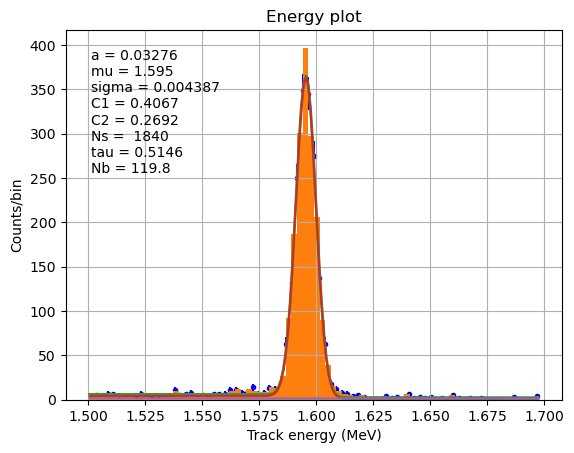

Signal events: 1840.1282769323655
Background events: 121.56652519146604
Total Events by addition: 1961.6948021238316
Total Events by row counting: 1959


Blob cut: 0.18 MeV
Mu fit completed, with values:
mu: 1.595473091928504
sigma: 0.0043573553141157085


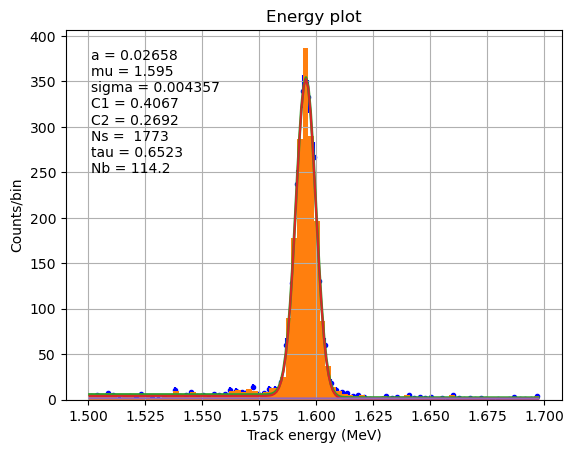

Signal events: 1772.9973668049463
Background events: 112.51878462860572
Total Events by addition: 1885.516151433552
Total Events by row counting: 1883


Blob cut: 0.19 MeV
Mu fit completed, with values:
mu: 1.595449677588095
sigma: 0.004383551857966106


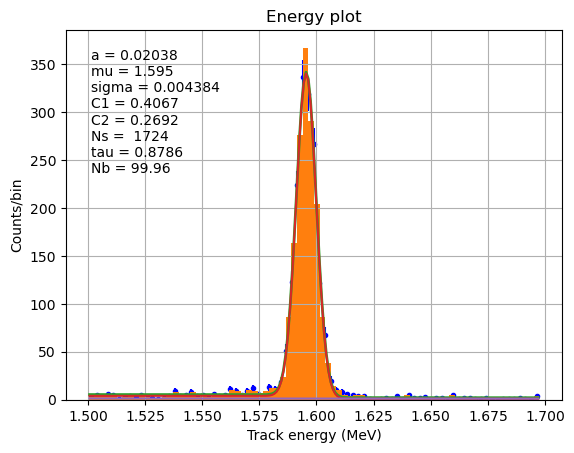

Signal events: 1724.0798238698744
Background events: 98.34823938098995
Total Events by addition: 1822.4280632508644
Total Events by row counting: 1820


Blob cut: 0.2 MeV
Mu fit completed, with values:
mu: 1.595393892675284
sigma: 0.004402194977268058


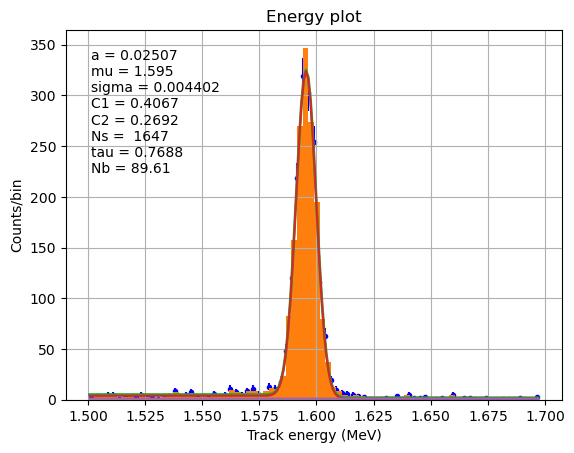

Signal events: 1647.2739235675785
Background events: 91.1415829891036
Total Events by addition: 1738.4155065566822
Total Events by row counting: 1736


Blob cut: 0.21 MeV
Mu fit completed, with values:
mu: 1.595409322104119
sigma: 0.004346000688838818


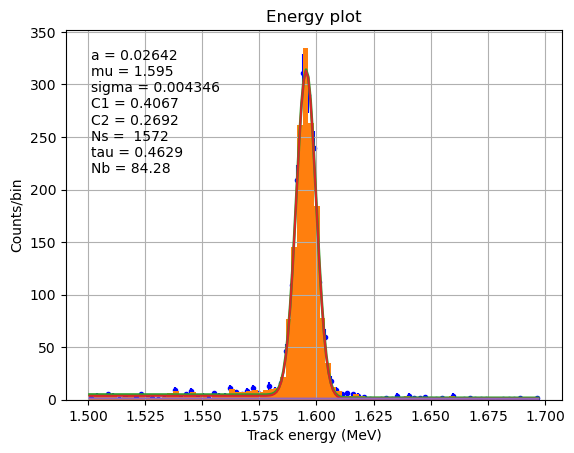

Signal events: 1572.378154244959
Background events: 82.83380184360583
Total Events by addition: 1655.2119560885649
Total Events by row counting: 1653


Blob cut: 0.22 MeV
Mu fit completed, with values:
mu: 1.5954274237275263
sigma: 0.004338291028782171


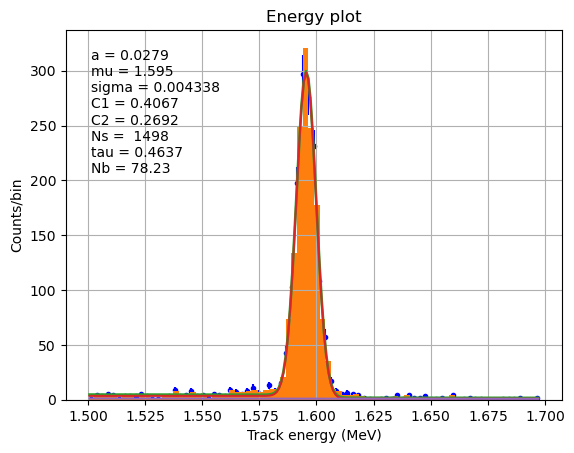

Signal events: 1497.5355461809781
Background events: 79.60163448423651
Total Events by addition: 1577.1371806652146
Total Events by row counting: 1575


Blob cut: 0.23 MeV
Mu fit completed, with values:
mu: 1.5955114163702733
sigma: 0.0044305761522063156


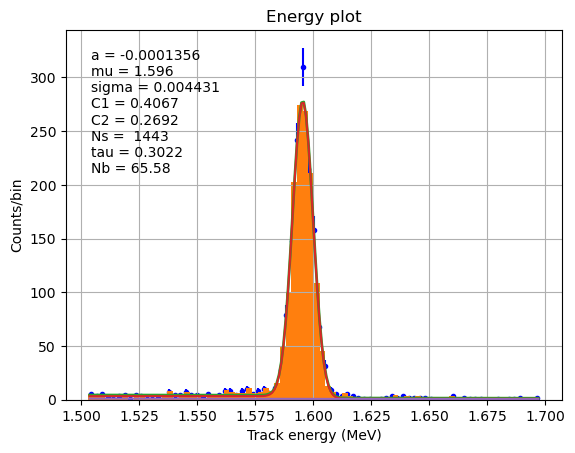

Signal events: 1442.8179766077149
Background events: 64.27375871796146
Total Events by addition: 1507.0917353256764
Total Events by row counting: 1500


Blob cut: 0.24 MeV
Mu fit completed, with values:
mu: 1.595439769435795
sigma: 0.004451361929793822


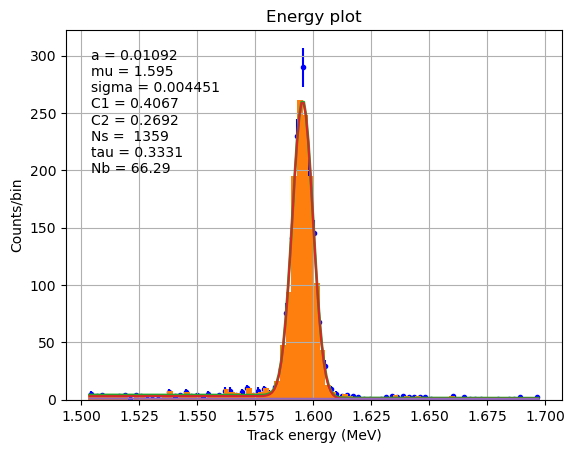

Signal events: 1358.7094595426122
Background events: 65.04278811497619
Total Events by addition: 1423.7522476575884
Total Events by row counting: 1417


Blob cut: 0.25 MeV
Mu fit completed, with values:
mu: 1.5953957393951206
sigma: 0.00444216911552441


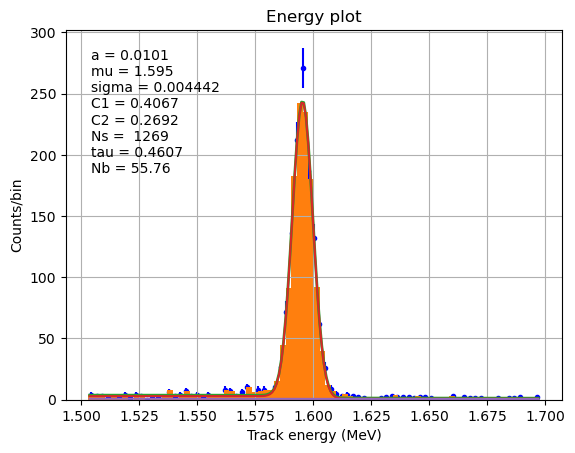

Signal events: 1269.3632804747126
Background events: 56.88318981548117
Total Events by addition: 1326.2464702901939
Total Events by row counting: 1320


Blob cut: 0.26 MeV
Mu fit completed, with values:
mu: 1.5953913800296284
sigma: 0.004451981273399173


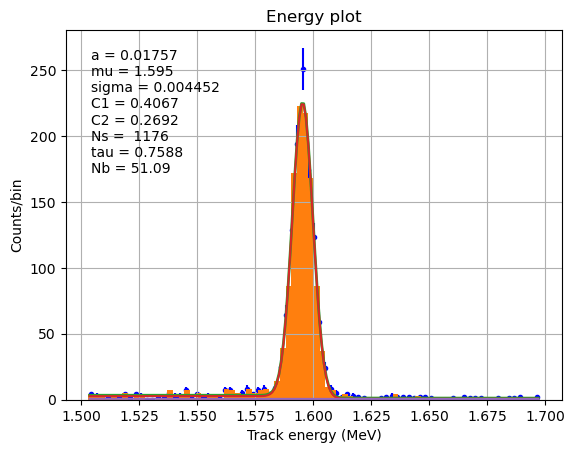

Signal events: 1175.6355629479792
Background events: 50.07248363134393
Total Events by addition: 1225.708046579323
Total Events by row counting: 1220


Blob cut: 0.27 MeV
Mu fit completed, with values:
mu: 1.595307402129917
sigma: 0.004484538088681858


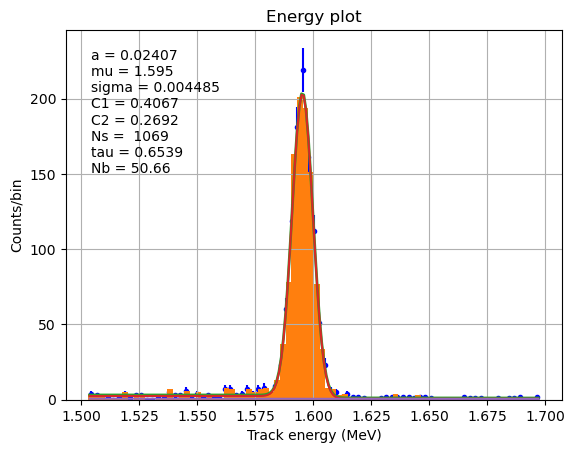

Signal events: 1069.4675325458759
Background events: 49.715776401202014
Total Events by addition: 1119.1833089470779
Total Events by row counting: 1114


Blob cut: 0.28 MeV
Mu fit completed, with values:
mu: 1.5952365833512248
sigma: 0.004423679646008409


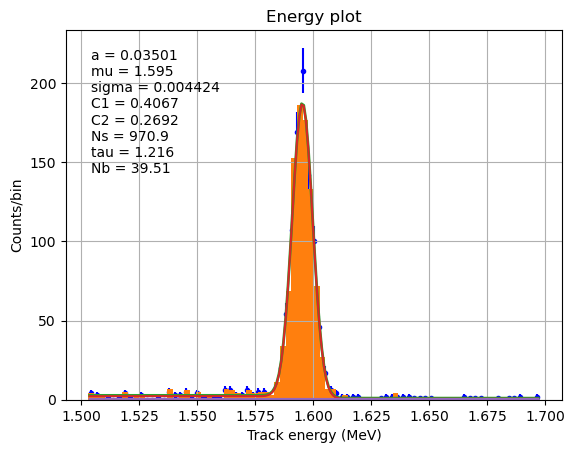

Signal events: 970.907100128616
Background events: 38.692490361259196
Total Events by addition: 1009.5995904898751
Total Events by row counting: 1005


Blob cut: 0.29 MeV
Mu fit completed, with values:
mu: 1.5952365202279657
sigma: 0.0043140041999566075


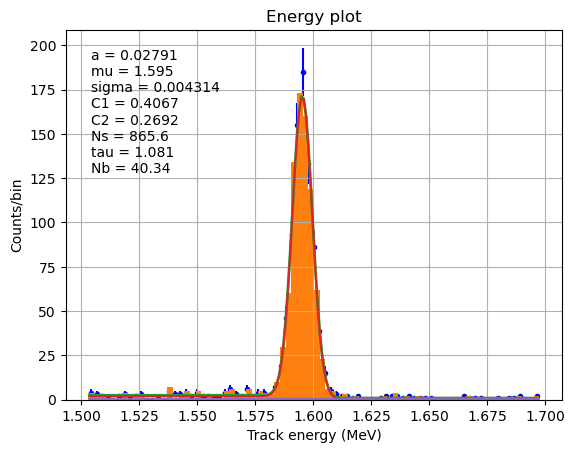

Signal events: 865.6415510113671
Background events: 39.594788395048944
Total Events by addition: 905.236339406416
Total Events by row counting: 901


Blob cut: 0.3 MeV
Mu fit completed, with values:
mu: 1.595183349632844
sigma: 0.004365809490594131


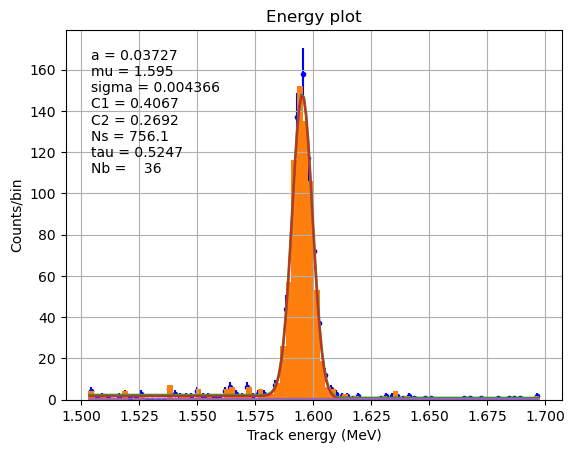

Signal events: 756.1420715491788
Background events: 36.66362377940372
Total Events by addition: 792.8056953285825
Total Events by row counting: 789


Blob cut: 0.31 MeV
Mu fit completed, with values:
mu: 1.5951946045154914
sigma: 0.004191397010690873


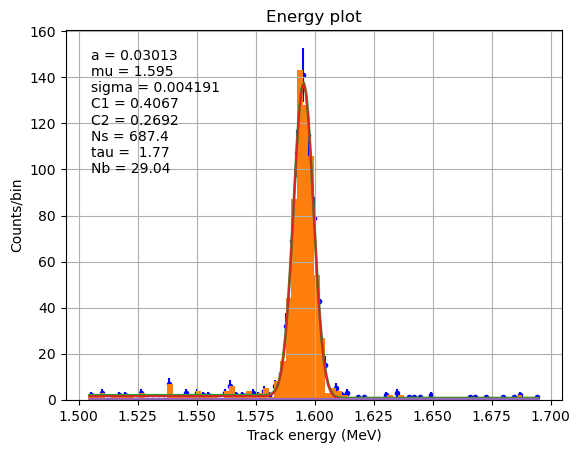

Signal events: 687.4202271438775
Background events: 28.466066638659346
Total Events by addition: 715.8862937825368
Total Events by row counting: 711


Blob cut: 0.32 MeV
Mu fit completed, with values:
mu: 1.5952675225832293
sigma: 0.00422618087062102


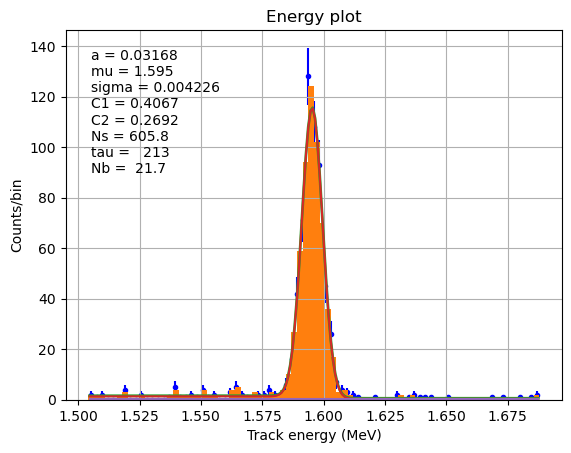

Signal events: 605.7805018868582
Background events: 21.20196533368343
Total Events by addition: 626.9824672205417
Total Events by row counting: 621


Blob cut: 0.33 MeV
Mu fit completed, with values:
mu: 1.5953248380901714
sigma: 0.004070031753990345


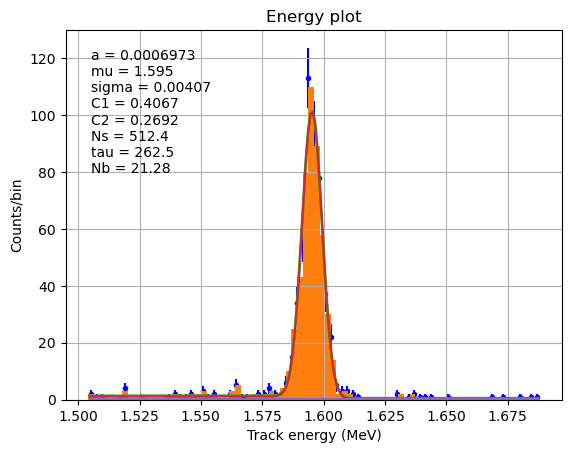

Signal events: 512.3842313554918
Background events: 20.860534930296843
Total Events by addition: 533.2447662857886
Total Events by row counting: 528


Blob cut: 0.34 MeV
Mu fit completed, with values:
mu: 1.5955389937267674
sigma: 0.004010854622237015


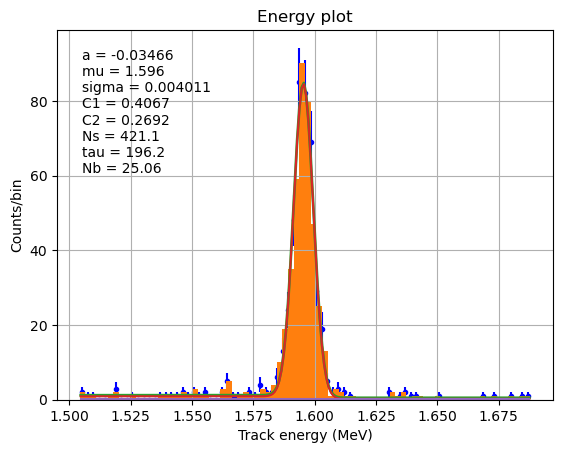

Signal events: 421.12655517327426
Background events: 24.686418133562764
Total Events by addition: 445.812973306837
Total Events by row counting: 441


Blob cut: 0.35 MeV
Mu fit completed, with values:
mu: 1.5956925509791537
sigma: 0.0038263116744223172


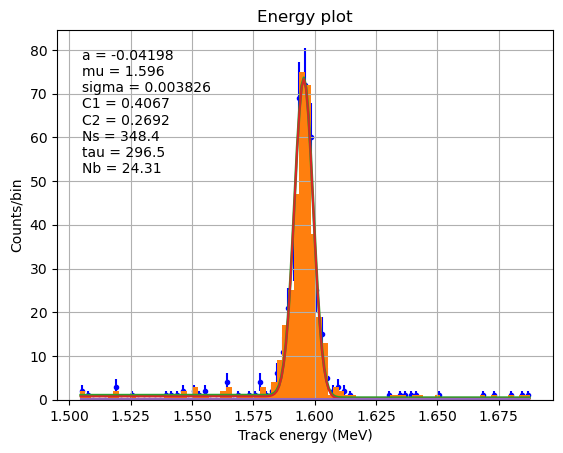

Signal events: 348.3503185957466
Background events: 23.990613091037158
Total Events by addition: 372.3409316867838
Total Events by row counting: 368


In [32]:
for i in range(len(cut_list)):
    # generate data
    blob_data = cut_tracks[0][(cut_tracks[0]['eblob2'] > cut_list[i])]
    print("")
    print("")
    print("====================================")
    print("Blob cut: {} MeV".format(cut_list[i]))
    print("====================================")
    # fit gaussian for mu and sigma    
    #holder = gaussian_fit(blob_data)
    #mu = holder[0]
    #sigma = holder[1]

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']
    binning = 80
    g_popt, g_pcov = func.histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("Mu fit completed, with values:\nmu: {}\nsigma: {}".format(mu,sigma))
    holder_sb = sb_fit(blob_data, mu, sigma, C1, C2, plot = True)

    ns_l.append(holder_sb[0])
    nb_l.append(holder_sb[1])

    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)))
    
    # efficiency and background rej
    e_check = ns_l[i]/ns_l[0]
    b_check = nb_l[i]/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)

    e.append(e_check)
    b.append(b_check)
    fom.append(fom_check)

        # errors for fom
    e_err.append(func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
    b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
    fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

    del blob_data, mu, sigma, g_popt, g_pcov, holder_sb

    print("====================================")

In [33]:
print(fom)
plot = True

[1.0, 1.0, 1.016463578214327, 1.0504859010865373, 1.1283526488778952, 1.2262477322990302, 1.3503710713682757, 1.4745747230019435, 1.5997239068679583, 1.7050279920620317, 1.8543688909982685, 2.0061839317145322, 2.1312917584069337, 2.1977728359515654, 2.2984617788383366, 2.4164844801484215, 2.467689212869629, 2.5110898060913787, 2.514876842624075, 2.615743906004575, 2.5961434598547384, 2.5994074030313774, 2.5254413939669123, 2.7077953814248157, 2.5348261094110836, 2.532299723140514, 2.499736869739006, 2.282136615435055, 2.348472521187812, 2.069856458569434, 1.8789138007810597, 1.9385621260715509, 1.9794675112937437, 1.6879290314655073, 1.2752776101857108, 1.0700810819679496]


VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   221466.6610722 Edm =       152867 NCalls =     11
VariableMetric: Iteration #   0 - FCN =   221466.6610722 Edm =       152867 NCalls =     11
VariableMetric: Iteration #   1 - FCN =  -45433.49578387 Edm =      3.24233 NCalls =     32
VariableMetric: Iteration #   2 - FCN =  -47387.59665699 Edm =      21.3433 NCalls =     47
VariableMetric: Iteration #   3 - FCN =  -47417.46503538 Edm =      1.57392 NCalls =     55
VariableMetric: Iteration #   4 - FCN =  -47421.37352002 Edm =     0.386177 NCalls =     63
VariableMetric: Iteration #   5 - FCN =  -47421.89157082 Edm =    0.0302811 NCalls =     71
VariableMetric: Iteration #   6 - FCN =  -47423.19952469 Edm =      1.11257 NCalls =     81
VariableMetric: Iteration #   7 - FCN =  -47787.71625605 Edm =      534.163 NCalls =     99
VariableMetric: Iteration #   8 - FCN =  -47788.87411038 Edm =     0.957382 NCalls =    107
VariableMetric: Iteration 

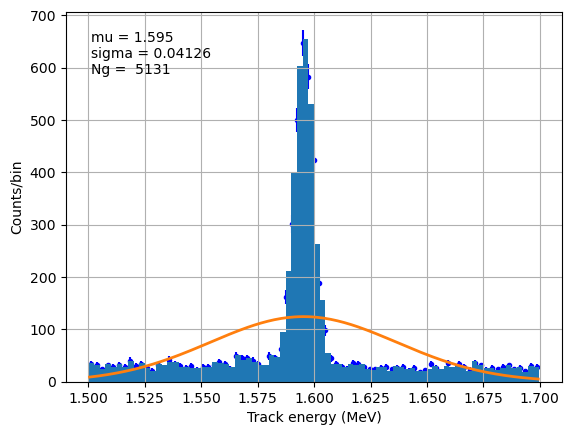

NameError: name 'pdf_sb' is not defined

In [ ]:
'''
for i in range(len(cut_list)):
    try:
        del lh_sb, vals_sb, nm_sb, m_sb, m_g, lh_g,
    except:
        pass
    # generate data
    blob_data = cut_tracks[0][(cut_tracks[0]['eblob2'] > cut_list[i])]
    blob_np = blob_data['energy'].to_numpy()

    # produce gaussian fit
    lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
    vals_g = [len(blob_np), 1.58, 0.004]
    nm_g = ['Ng', 'mu', 'sigma']

    m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1),  print_level = 2)
    
    # minimise it
    m_g.migrad()

    print("Finished fitting gaussian")
    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_np, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_g.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
    mu = fit_params['mu']
    sigma = fit_params['sigma']

    # now do full fit
    try:
        del lh_sb, vals_sb, nm_sb, m_sb
    except:
        pass
    lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)
    
    y, x = np.histogram(blob_np, fit_bins)
    x = shift_to_bin_centers(x)
    
    # give it rough starting spots
    vals_sb = [fit_params['Ng'], len(blob_np) - fit_params['Ng'], 0, mu, sigma, 100, C1, C2]
    nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']

    m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, print_level = 2)

    # minimise that mfer
    m_sb.migrad()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

    ns_l.append(fit_params['Ns'])
    nb_l.append(fit_params['Nb'])

    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(fit_params['Ns'], fit_params['Nb'],fit_params['Nb'] + fit_params['Ns'], len(blob_data[0].index)))

    # efficiency and background rej
    e_check = fit_params['Ns']/ns_l[0]
    b_check = fit_params['Nb']/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)

    e.append(e_check)
    b.append(b_check)
    fom.append(fom_check)

        # errors for fom
    e_err.append(func.ratio_error(e[i],ns[i],ns[0],np.sqrt(ns[i]),np.sqrt(ns[0])))
    b_err.append(func.ratio_error(b[i],nb[i],nb[0],np.sqrt(nb[i]),np.sqrt(nb[0])))
    fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

    del blob_data
'''

In [28]:
print(fom)

[1.0, 1.0, 1.0191338832617622, 1.0526770091069353, 1.1165626929952381, 1.2109149984702658, 1.3414284045991791, 1.426255062507989, 1.506349355898789, 1.5500329010487817, 1.6557822542169787, 1.692943200529066, 1.695086497249963, 1.7118273626762903, 1.7237728914028085, 1.755233136888712, 1.7660415535971175, 1.7488804869853385, 1.7180355115364057, 1.725846792296573, 1.6724225976529061, 1.649647514191557, 1.629504439678623, 1.6417503009068402, 1.6142094737764727, 1.5391458251190533, 1.4933876350979571, 1.3784057386888517, 1.3330662917622105, 1.2433717637607506, 1.1067606926162856, 1.0905171287175952, 0.9985136853249034, 1.0058316002788035, 0.7285759257156111, 0.6770295437181519, 0.9458133933846413, 0.72994291812275, 0.4747425217946377, 0.4272812380112705, 0.20335731462578585, 0.07529845031882201, 1.007206953926349, 5.789617030355163, 0.0724704681063013]


In [29]:
cut_list = np.linspace(0,0.35, 36)

No handles with labels found to put in legend.


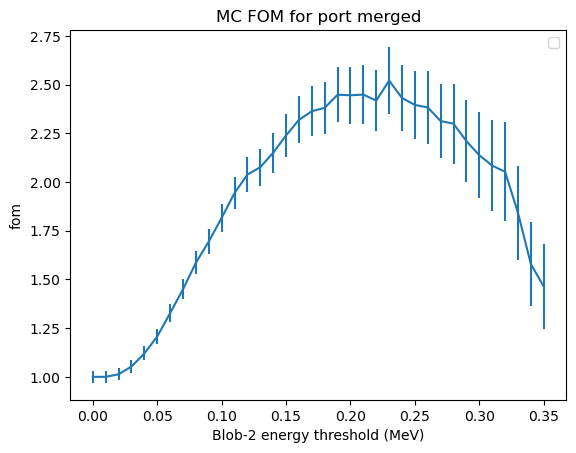

In [34]:
fom_MC = func.true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

ns = fom_MC[2]
nb = fom_MC[3]
fom_erro = np.nan_to_num(fom_MC[1])
fom_out = np.nan_to_num(fom_MC[0])

plt.errorbar(cut_list, fom_out, yerr = fom_erro)
plt.title("MC FOM for port merged")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.legend()

plt.ylabel("fom")
plt.show()

In [31]:
print(len(fom))

45


In [35]:
cut_list_fit = np.linspace(0,0.35, 36)

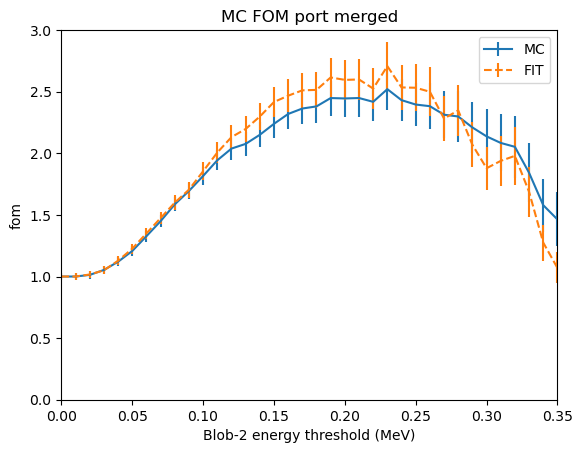

In [37]:
plt.errorbar(cut_list, fom_out, yerr = fom_erro, label = 'MC')
plt.errorbar(cut_list_fit, fom, yerr = fom_err, label = 'FIT', linestyle = 'dashed')
plt.legend()
plt.title("MC FOM port merged")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.xlim([0,0.35])
plt.ylim([0,3])
plt.ylabel("fom")
plt.show()

In [91]:
'''
e_s2 = np.append(e_s, e_s2)
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s2, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s2, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s2), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s2), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m2 = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)
'''

In [38]:
np.save('data/fom_fit_merged_12_12_18.npy', fom)
np.save('data/fom_fit_err_merged_12_12_18.npy', fom_err)
#np.save('data/fom_MC_isaura_1a.npy', fom_out)
#np.save('data/fom_MC_err_isaura_1a.npy', fom_erro)

In [92]:
'''
# minimise that mfer
m2.migrad()
heights, bins, _ = plt.hist(e_s2, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)
plt.show()
'''

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   0 - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   1 - FCN =  -103883.8363617 Edm =      6118.56 NCalls =    119
VariableMetric: Iteration #   2 - FCN =  -108560.6179698 Edm =       914.85 NCalls =    143
VariableMetric: Iteration #   3 - FCN =  -108715.0329486 Edm =      451.082 NCalls =    159
VariableMetric: Iteration #   4 - FCN =  -108822.0763603 Edm =      29.2179 NCalls =    173
VariableMetric: Iteration #   5 - FCN =  -108830.6308968 Edm =      14.9261 NCalls =    187
VariableMetric: Iteration #   6 - FCN =  -108842.8533993 Edm =      4.13233 NCalls =    201
VariableMetric: Iteration #   7 - FCN =  -108850.6622825 Edm =      1.94108 NCalls =    215
VariableMetric: Iteration #   8 - FCN =  -108871.5466668 Edm =      10.4149 NCalls =    233
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.089e+05                 │        Nfcn = 376 (376 total)        │
│ EDM = 2.87e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.49    │   0.28    │            │            │         │         │       │
│ 1 │ mu    │  1.5939   │  0.0008   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.73e-3  │  0.31e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.361   │   0.023   │            │            │    0    │         │       │
│ 4 │ C2    │   0.297   │   0.020   │            │            │    0    │         │       │
│ 5 │ Ns    │  9.39e3   │  0.10e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [36]:
test = np.load('data/fom_fit.npy')
print(test)

[1.         1.         1.00783633 1.03175901 1.08084012 1.16535834
 1.25313252 1.37277737 1.49315832 1.617329   1.71711929 1.80310433
 1.91390578 2.05241509 2.18071868 2.32241737 2.43892065 2.51700152
 2.49711649 2.51333411 2.53407889 2.54255474 2.55964242 2.53972371
 2.5362615  2.52928113 2.52160151 2.48350147 2.52386446 2.51541374
 2.34044961 2.49881868 2.45386654 2.39762317 2.41270768 2.34797239
 2.14480602 2.1104387  2.0348056  1.65507467 1.46494797 1.51717247
 1.51303867 1.30528955 1.14064372 1.34130759 1.05922434 0.91590526
 0.7165015  0.53646691 0.3310788  0.3378764  0.21455947 0.14866301
 0.09503777 0.06944191 0.00874405 0.02292246        nan        nan
        nan]
